In [1]:
import os
import sys
import pyet
import xarray as xr
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer


sys.path.append('../src')
from evapo_bibli                  import *

MAIN_PATH = os.path.dirname(os.path.abspath(''))
DATA_PATH = os.path.join(MAIN_PATH, 'data')
CLIMA_PATH = os.path.join(DATA_PATH, '01_raw')
DB_PATH = os.path.join(DATA_PATH, '02_intermediate')

NOTE_PATH = os.path.join(MAIN_PATH, 'notebooks')
CODE_PATH = os.path.join(MAIN_PATH, 'src')

In [4]:
df = pd.read_parquet("clima_sp_2011_2020.parquet")

In [2]:
# Função para converter hora para datetime
def converter_hora(hora_str):
    try:
        # Tenta converter para o formato '0000 UTC'
        return pd.to_datetime(hora_str, format='%H%M UTC')
    except ValueError:
        # Se não for possível converter para o formato '0000 UTC', tenta converter para o formato '00:00'
        return pd.to_datetime(hora_str, format='%H:%M')
    
# Função para converter data para datetime
def converter_data(data_str):
    try:
        return pd.to_datetime(data_str, format='%Y/%m/%d')
    except ValueError:
        return pd.to_datetime(data_str, format='%Y-%m-%d')

def determinar_estacao(dia, mes):
    if (mes == 12 and dia >= 22) or (mes == 1) or (mes == 2) or (mes == 3 and dia <= 20):
        return 'Verão'
    elif (mes == 3 and dia > 20) or (mes == 4) or (mes == 5) or (mes == 6 and dia < 21):
        return 'Outono'
    elif (mes == 6 and dia >= 21) or (mes == 7) or (mes == 8) or (mes == 9 and dia < 23):
        return 'Inverno'
    elif (mes == 9 and dia >= 23) or (mes == 10) or (mes == 11) or (mes == 12 and dia < 22):
        return 'Primavera'
    else:
        return 'Data inválida'
     
def ml_error(model_name, y, yhat):
    """Cria um dataframe que traz as metricas MAE, MAPE, RMSE e R2 do modelo treinado

    Args:
        model_name (string): Nome do modelo
        y (_type_): Variavel target 
        yhat (_type_): Variavel target predita

    Returns:
        DataFrame: Dataframe com as métricas de desempenho do modelo
    """
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y,yhat)
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE':rmse,
                         'R2': r2}, index=[0])

In [10]:
aux = df.copy()

aux['hora'] = aux['hora'].apply(converter_hora)
aux['data'] = aux['data'].apply(converter_data)

aux['data_hora'] = aux['data'] + pd.to_timedelta(aux['hora'].dt.hour, unit='h') + pd.to_timedelta(aux['hora'].dt.minute, unit='m')

aux.drop(columns=['hora', 'data'], inplace=True)
aux.rename(columns={'data_hora': 'data'}, inplace=True)

aux['dia'] = aux['data'].dt.day
aux['mes'] = aux['data'].dt.month
aux['ano'] = aux['data'].dt.year

aux['temperatura_max'] = aux['temperatura_max'].str.replace(',', '.').astype(float)
aux['temperatura_min'] = aux['temperatura_min'].str.replace(',', '.').astype(float)
aux['vento_velocidade'] = aux['vento_velocidade'].str.replace(',', '.').astype(float)
aux['radiacao_global'] = aux['radiacao_global'].str.replace(',', '.').astype(float)
aux['ALTITUDE'] = aux['ALTITUDE'].str.replace(',', '.').astype(float)
aux['LATITUDE'] = aux['LATITUDE'].str.replace(',', '.').astype(float)
aux['LONGITUDE'] = aux['LONGITUDE'].str.replace(',', '.').astype(float)
aux['precipitacao_total'] = aux['precipitacao_total'].str.replace(',', '.').astype(float)

In [67]:
aux.to_parquet("clima_sp_2011_2020_trans.parquet")

In [3]:
aux = pd.read_parquet("clima_sp_2011_2020_trans.parquet")

In [68]:
aux2 = aux.copy()

aux2['temperatura_min'] = aux2['temperatura_min'].replace(0, np.nan)
aux2['temperatura_min'] = aux2['temperatura_min'].mask(aux2['temperatura_min'] < 0)
aux2['temperatura_max'] = aux2['temperatura_max'].replace(0, np.nan)
aux2['temperatura_max'] = aux2['temperatura_max'].mask(aux2['temperatura_max'] < 0)
aux2['umidade_rel'] = aux2['umidade_rel'].mask(aux2['umidade_rel'] < 0)
aux2['radiacao_global'] = aux2['radiacao_global'].replace(0, np.nan)
aux2['radiacao_global'] = aux2['radiacao_global'].mask(aux2['radiacao_global'] < 0)
aux2['vento_velocidade'] = aux2['vento_velocidade'].mask(aux2['vento_velocidade'] < 0)
aux2['precipitacao_total'] = aux2['precipitacao_total'].mask(aux2['precipitacao_total'] < 0)

aux2['temperatura_max'] = aux2['temperatura_max'].fillna(aux2.groupby(['mes', 'dia'])['temperatura_max'].transform('median'))
aux2['temperatura_min'] = aux2['temperatura_min'].fillna(aux2.groupby(['mes', 'dia'])['temperatura_min'].transform('median'))
aux2['vento_velocidade'] = aux2['vento_velocidade'].fillna(aux2.groupby(['mes', 'dia'])['vento_velocidade'].transform('median'))
aux2['umidade_rel'] = aux2['umidade_rel'].fillna(aux2.groupby(['mes', 'dia'])['umidade_rel'].transform('median'))
aux2['radiacao_global'] = aux2['radiacao_global'].fillna(aux2.groupby(['mes', 'dia'])['radiacao_global'].transform('median'))
aux2['precipitacao_total'] = aux2['precipitacao_total'].fillna(aux2.groupby(['mes', 'dia'])['precipitacao_total'].transform('median'))

aux2 = aux2.groupby(['ESTAÇÃO', 'ano', 'mes', 'dia']).agg({'temperatura_max': 'mean',
                                              'temperatura_min': 'mean',
                                              'umidade_rel': 'median',
                                              'radiacao_global': 'sum',
                                              'vento_velocidade': 'median',
                                              'precipitacao_total': 'sum',
                                              'LATITUDE': 'median',
                                              'LONGITUDE': 'median',
                                              'ALTITUDE': 'median',}).reset_index()

aux2['temperatura_media'] = (aux2['temperatura_min'] + aux2['temperatura_max']) / 2

aux2['radiacao_global'] = aux2['radiacao_global']/1000/12

aux2['data'] = pd.to_datetime(aux2['ano'].astype(str) + '-' + aux2['mes'].astype(str) + '-' + aux2['dia'].astype(str))

aux2['lat_rad'] = np.deg2rad(aux2['LATITUDE'])

aux2.set_index('data', inplace=True)

In [69]:
clima = aux2[['temperatura_max', 'temperatura_min', 'temperatura_media', 'umidade_rel', 'radiacao_global', 'vento_velocidade', 'precipitacao_total', 'lat_rad', 'ALTITUDE']]

tmax, tmin, tmean, rh, rs, wind, ppt, lat, elev = [clima[column] for column in clima.columns]

aux2['ET0_fao'] = pyet.pm_fao56(tmean, wind, tmax=tmax, rs=rs, tmin=tmin, rh=rh, elevation=elev, lat=lat)
aux2 = aux2[aux2['ESTAÇÃO'] != 'CRIOSFERA']


e:\repos\estudo_clima\env_clima\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [78]:
#Mantem a data como index e adiciona as colunas LATITUDE, LONGITUDE e ALTITUDE como index
aux3 = aux2.copy()

aux3['data'] = aux2.index
aux3 = aux3.set_index(['data', 'LATITUDE', 'LONGITUDE'])


In [79]:
aux4 = aux3.to_xarray()

In [90]:
temp_media_global = aux4['ET0_fao'].mean(dim=('LATITUDE', 'LONGITUDE'))

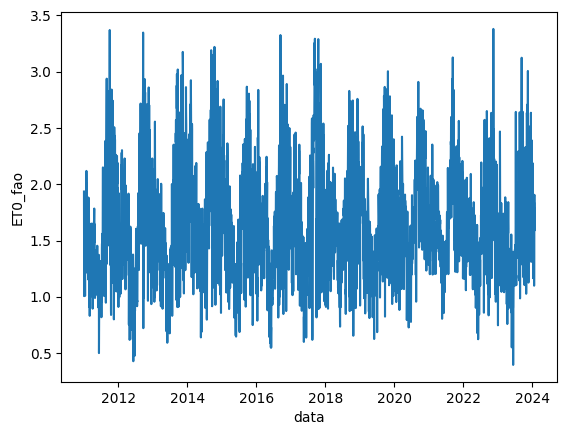

In [91]:
temp_media_global.plot()

In [94]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequence = data[i:i+seq_length]
        sequences.append(sequence)
    return np.array(sequences)

def r_squared(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res/(SS_tot + tf.keras.backend.epsilon())

In [105]:
aux2.dtypes

ESTAÇÃO                object
ano                     int32
mes                     int32
dia                     int32
temperatura_max       float64
temperatura_min       float64
umidade_rel           float64
radiacao_global       float64
vento_velocidade      float64
precipitacao_total    float64
LATITUDE              float64
LONGITUDE             float64
ALTITUDE              float64
temperatura_media     float64
lat_rad               float64
ET0_fao               float64
dtype: object

In [118]:
X_treino = aux2[aux2.index.year < 2019].drop(columns=['ET0_fao', 'ESTAÇÃO'])
y_treino = aux2[aux2.index.year < 2019]['ET0_fao']

X_val = aux2[aux2.index.year == 2023].drop(columns=['ET0_fao', 'ESTAÇÃO'])
y_val = aux2[aux2.index.year == 2023]['ET0_fao']

timesteps = 365

# Criando sequências para X_treino e y_treino
X_treino_sequences = create_sequences(X_treino, timesteps)
y_treino_sequences = y_treino[timesteps-1:]

X_val_sequences = create_sequences(X_val, timesteps)
y_val_sequences = y_val[timesteps-1:]


In [119]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

# Definindo os parâmetros do modelo
input_dim = 14  # Dimensão da entrada (número de features)
hidden_units = 64  # Número de unidades ocultas na camada RNN
output_dim = 1  # Dimensão da saída (regressão univariada)

# Criando o modelo RNN
model = Sequential([
    LSTM(hidden_units, 
         input_shape=(None, input_dim),
         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2 no kernel da camada LSTM
         recurrent_regularizer=regularizers.l2(0.01),  # Regularização L2 na recorrência da camada LSTM
         bias_regularizer=regularizers.l2(0.01)),  # Regularização L2 no viés da camada LSTM
    Dense(output_dim, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))  # Regularização L2 na camada Dense
])
# Compilando o modelo
model.compile(optimizer='adam', loss='mse', metrics=[r_squared, tf.keras.metrics.RootMeanSquaredError(name='rmse')])

# Exibindo um resumo do modelo
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                20224     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 20289 (79.25 KB)
Trainable params: 20289 (79.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [120]:
model.fit(X_treino_sequences, y_treino_sequences, epochs=100, validation_data=(X_val_sequences, y_val_sequences))

MemoryError: Unable to allocate 1.82 GiB for an array with shape (95842, 365, 14) and data type float32